In [69]:
# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import json

In [70]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Dataset split: 60000 train rows
Dataset split: 10000 test rows


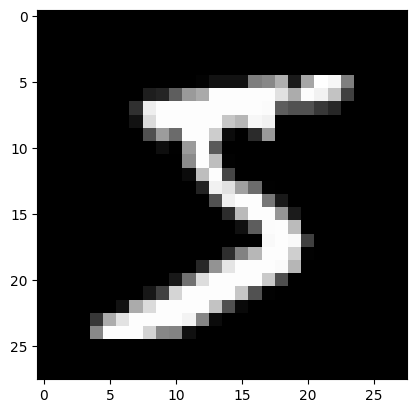

In [71]:
print(f"Dataset split: {len(train_images)} train rows")
print(f"Dataset split: {len(test_images)} test rows")

point = train_images[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [72]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [73]:
# normalize data
train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

# reshape
train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

In [74]:
print(train_images.shape)
print(test_images.shape)

(60000, 784)
(10000, 784)


In [75]:
latent_dim = 2

In [76]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(256, activation='relu')(vae_input)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [77]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [78]:
z = keras.layers.Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [79]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoded = x

In [80]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [81]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [82]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [83]:
# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [84]:
vae.compile(optimizer='adam')

In [85]:
# Adding the early stopping callback to the fit method
history = vae.fit(train_images, train_images, epochs=100, batch_size=64, validation_data=(test_images, test_images), callbacks=[early_stopping])

Epoch 1/100


938/938 [==============================] - 6s 5ms/step - loss: 0.0716 - val_loss: 0.0679
Epoch 2/100
938/938 [==============================] - 4s 5ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 3/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 4/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 5/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 6/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 7/100
938/938 [==============================] - 4s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 8/100
938/938 [==============================] - 4s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 9/100
938/938 [==============================] - 5s 5ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 10/100
938/938 [==============================] - 4s 5ms/step - loss: 0.0673 - val_loss: 0.0675
E

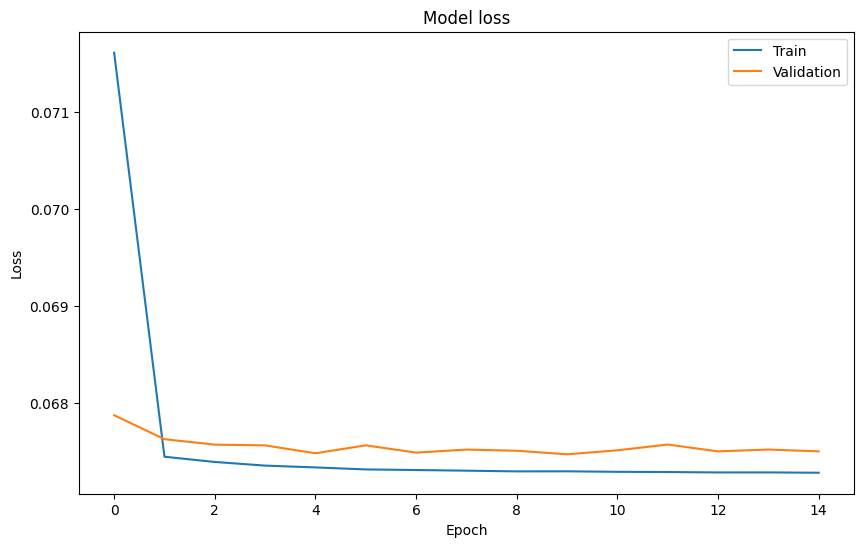

In [86]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [87]:
decoded_images = vae.predict(test_images)

# calculate the reconstruction error for each sample
reconstruction_errors = np.mean(np.square(test_images - decoded_images), axis=1)

313/313 [==============================] - 0s 1ms/step


In [88]:
# define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [89]:
# Classify anomalies based on the threshold
predictions = (reconstruction_errors > threshold).astype(int)

In [90]:
# Get corresponding labels for anomaly indexes
anomaly_labels = [test_labels[i] for i in anomaly_indexes]

# Print or use anomaly_indexes and anomaly_labels as needed
print("Anomaly Indexes:", anomaly_indexes)
print("Anomaly Labels:", anomaly_labels)

Anomaly Indexes: [  25   54   71  183  200  222  246  287  296  305  311  380  405  437
  440  461  462  475  549  556  559  602  611  648  656  665  701  719
  736  737  742  792  864  871  876  894  937  972  995  997 1060 1069
 1084 1101 1102 1162 1203 1223 1263 1348 1352 1377 1379 1390 1419 1457
 1526 1529 1574 1589 1610 1671 1692 1720 1748 1790 1801 1870 1892 1895
 1995 2060 2115 2140 2145 2170 2237 2293 2304 2319 2337 2371 2376 2385
 2436 2462 2464 2492 2536 2627 2641 2649 2664 2728 2747 2749 2758 2779
 2801 2802 2817 2826 2830 2842 2896 2929 2972 2996 3011 3013 3016 3031
 3120 3170 3179 3182 3242 3290 3364 3422 3447 3517 3521 3524 3540 3542
 3584 3602 3608 3624 3660 3665 3727 3734 3735 3768 3803 3817 3818 3835
 3841 3849 3883 3966 3980 3982 4033 4034 4043 4070 4082 4086 4139 4150
 4154 4155 4157 4188 4223 4294 4320 4348 4392 4462 4505 4554 4558 4571
 4601 4604 4611 4614 4628 4688 4724 4743 4757 4768 4776 4804 4833 4854
 4862 4992 4999 5031 5035 5043 5069 5079 5087 5108 5109 5124

In [91]:
# Get all the anomalies from the test_images
anomalies = test_images[anomaly_indexes]

print(len(anomalies))

500


In [92]:
# Get anomaly labels
anomaly_indexes = np.array(anomaly_indexes, dtype=int)
label_of_anomalies = [test_labels[i] for i in anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [93]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [94]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


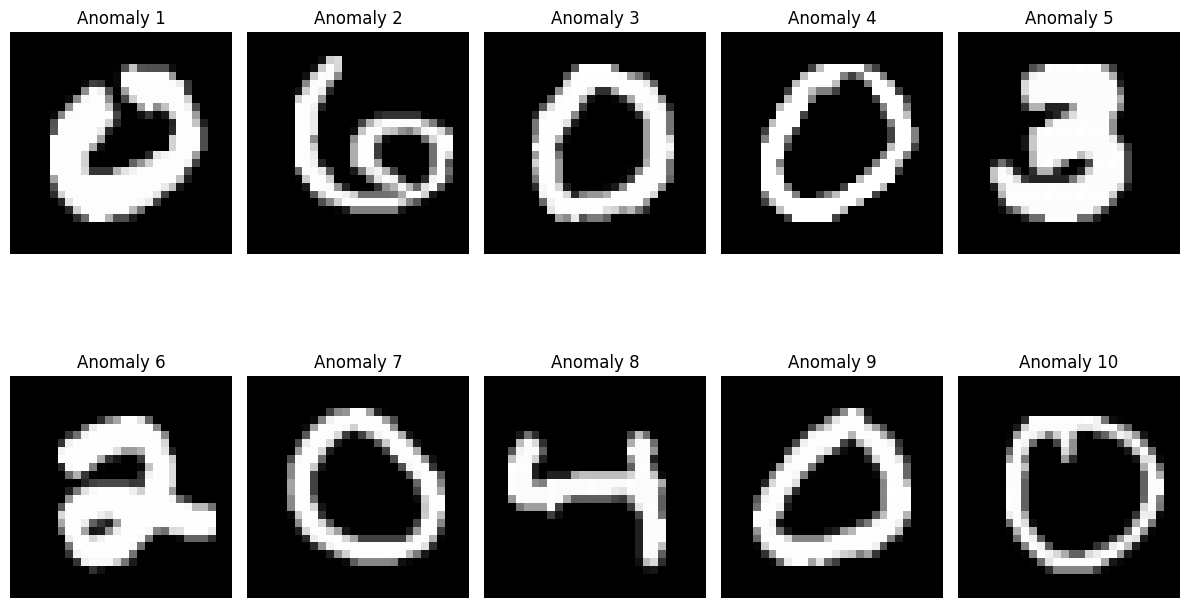

In [95]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


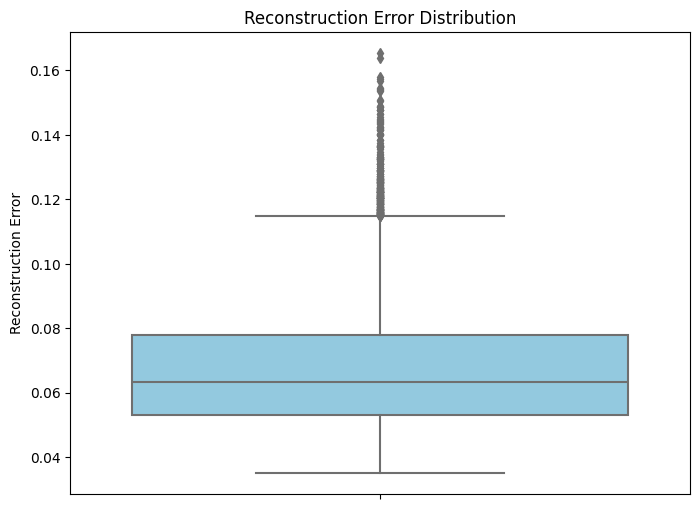

In [96]:
# Plot a boxplot of the reconstruction errors
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_errors, color='skyblue')
plt.title('Reconstruction Error Distribution')
plt.ylabel('Reconstruction Error')
plt.show()

In [97]:
# Map the class labels to "anomaly" and "normal"
class_labels = {0: 'normal', 1: 'anomaly'}
predictions_mapped = np.vectorize(class_labels.get)(predictions)
y_test_mapped = np.vectorize(class_labels.get)(test_labels)

In [98]:
# Ensure that y_test_mapped and predictions_mapped are binary (0 or 1)
y_test_mapped_binary = np.where(y_test_mapped == 'anomaly', 1, 0)
predictions_mapped_binary = np.where(predictions_mapped == 'anomaly', 1, 0)

313/313 [==============================] - 0s 972us/step


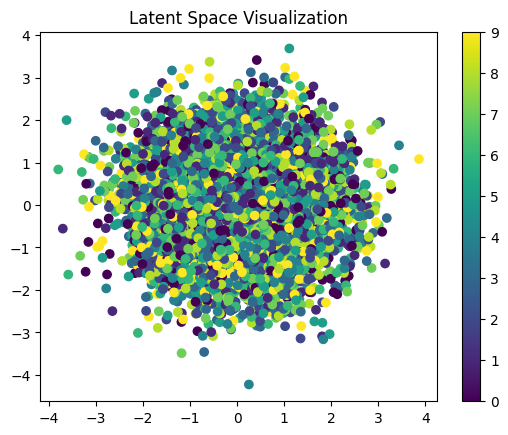

In [99]:
# Visualize the latent space
latent_space = encoder.predict(test_images)[2]

# Scatter plot of the latent space
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=test_labels, cmap='viridis')
plt.colorbar()
plt.title('Latent Space Visualization')
plt.show()

In [100]:
# Calculate metrics with 'binary' average setting
accuracy = accuracy_score(y_test_mapped_binary, predictions_mapped_binary)
precision = precision_score(y_test_mapped_binary, predictions_mapped_binary)
recall = recall_score(y_test_mapped_binary, predictions_mapped_binary)
f1 = f1_score(y_test_mapped_binary, predictions_mapped_binary)

In [101]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8365
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [102]:
report = classification_report(y_test_mapped_binary, predictions_mapped_binary, target_names=['normal', 'anomaly'])

# Print or use the classification report as needed
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      normal       0.88      0.94      0.91      8865
     anomaly       0.00      0.00      0.00      1135

    accuracy                           0.84     10000
   macro avg       0.44      0.47      0.46     10000
weighted avg       0.78      0.84      0.81     10000



In [103]:
# calculate the precision and recall for different threshold levels
precision_curve, recall_curve, _ = precision_recall_curve(y_test_mapped_binary, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall_curve, precision_curve)

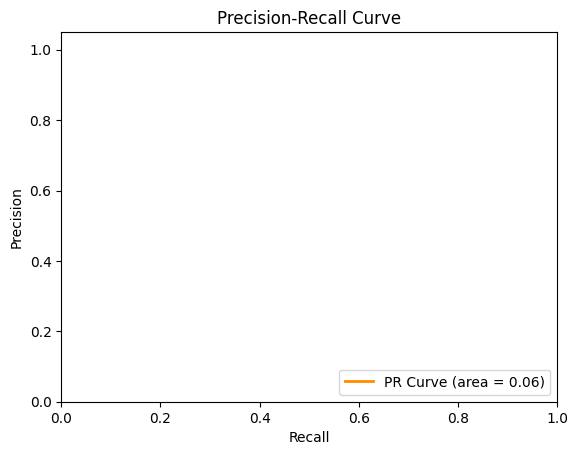

In [104]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [105]:
conf_matrix = confusion_matrix(y_test_mapped_binary, predictions_mapped_binary)

In [106]:
print(conf_matrix)

[[8365  500]
 [1135    0]]


In [108]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 8365
False Positives: 500
False Negatives: 1135
True Positives: 0
